# 參數設定 (使用訊號分解)

In [1]:
import os

labels = ['GroupCount']
model_type = 2 # 使用模型
predicteds = [1] # 預測類別 
batch_size = 14  # 批次大小

# labels = ['GroupCount']
# model_type = 1 # 使用模型
# predicteds = [1] # 預測類別 
# batch_size = 14  # 批次大小


# ==== 底下的參數基本上都不要亂動 ====
past_day = 14  # 過去天數，用於訓練資料中的歷史資料長度
future_day = 1

train_split_rate = 0.8  # 訓練集佔整體資料集的比例
val_split_rate = 0.1 # 驗證集占整體資料集的比例

is_emd = False # 是否使用 EMD，False 則使用 EEMD
 
model_dir = 'DecompEEMD/_Model'

# !pip install EMD-signal
# https://github.com/laszukdawid/PyEMD/tree/master

# 定義類別

In [2]:
import joblib

# 重新載入 Lib，讓檔案可以直接修改使用 
import importlib
import LstmLib 
importlib.reload(LstmLib)   

from LstmLib import * 
lstm = LstmLib()

import sys
print(sys.prefix)

/Users/elliesu/Developer/nckuenv


# 清除舊的訓練資料

In [3]:
x_scaler_file_name, y_scaler_file_name, model_file_name, result_file_name = \
    lstm.reset_data(model_dir, labels, model_type, predicteds, batch_size)

x_scaler_file_name: DecompEEMD/_Model/GroupCount_mt2_data1_batch14.x_scaler.pkl
y_scaler_file_name: DecompEEMD/_Model/GroupCount_mt2_data1_batch14.y_scaler.pkl
model_file_name: DecompEEMD/_Model/GroupCount_mt2_data1_batch14.model.keras
result_file_name: DecompEEMD/_Model/GroupCount_mt2_data1_batch14.result.json
檔案 DecompEEMD/_Model/GroupCount_mt2_data1_batch14.result.json 存在，已刪除


# 載入數據

In [4]:
df_source = lstm.load_data(predicteds)

print(len(df_source))
df_source.head()

# 載入數據
395


,RequestTime,Predicted,SendBytes,ReceiveBytes,TimeTaken,UrlType1,UrlType2,UrlType3,Method_GET,Method_POST,Method_PUT,Method_DELETE,Method_HEAD,Method_OPTIONS,Method_PATCH,GroupCount
0,2023-04-02,[1],133985276,9489146,1284508,9923,0,0,8410,1513,0,0,0,0,0,9923
1,2023-04-03,[1],173845707,12345851,1795732,13065,0,0,11090,1975,0,0,0,0,0,13065
2,2023-04-04,[1],179977352,13984392,1640886,14207,0,0,11796,2411,0,0,0,0,0,14207
3,2023-04-05,[1],163981342,15044918,1672361,15636,0,0,13201,2435,0,0,0,0,0,15636
4,2023-04-06,[1],386294578,38072811,4094537,38862,0,0,32274,6587,0,1,0,0,0,38862


# 訊號分解

# 訊號分解
EEMD


IMFs shape : (8, 395)
eIMFs shape : (8, 395)
residue shape : (395,)


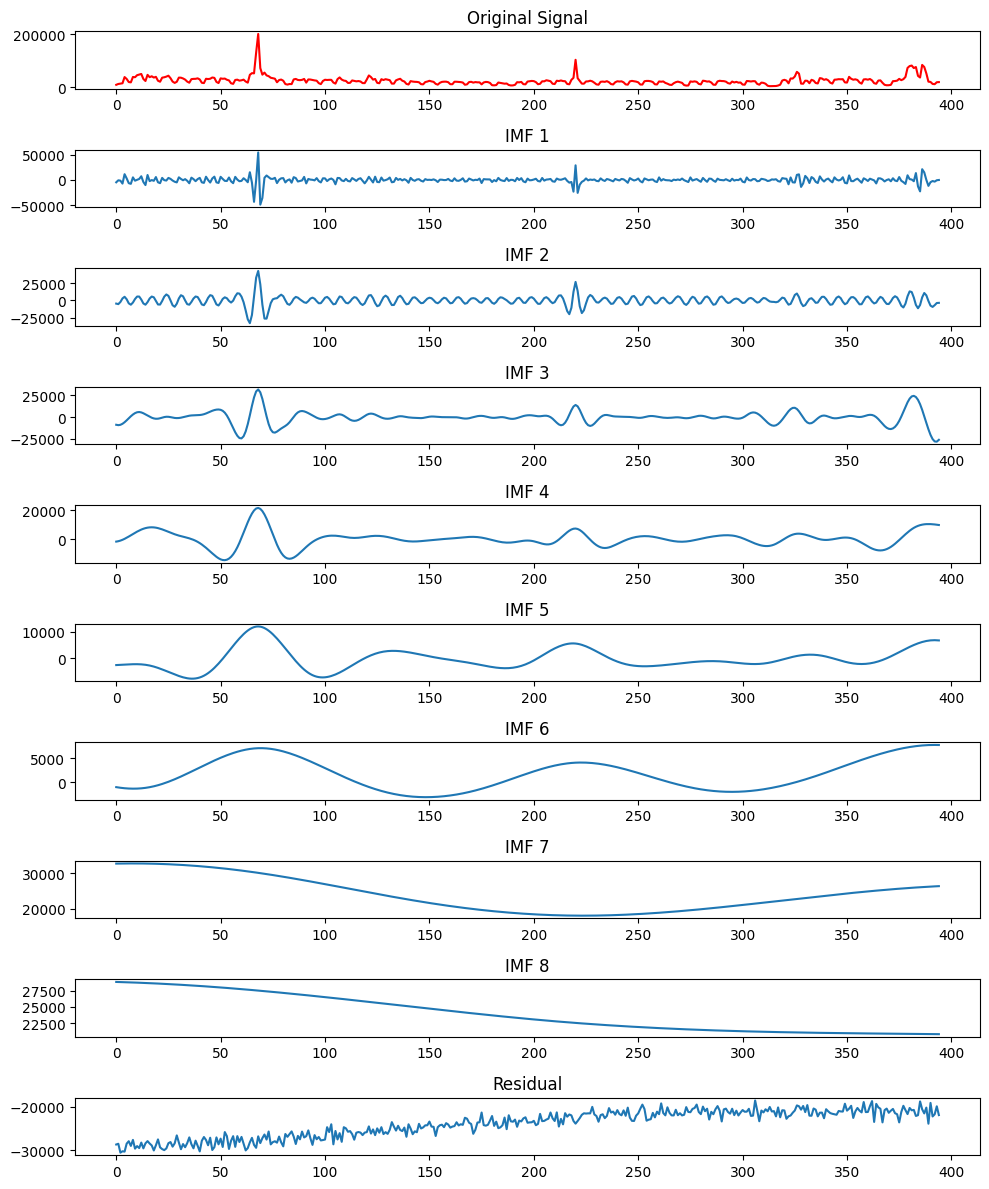

In [5]:
data_source = df_source[labels].values
eIMFs, residue, imfs = lstm.decomposition(data_source, is_emd = is_emd)

# 刪除訊號分解後的訓練資料

In [6]:
def print_step(index):
    print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
    # 最後一個是殘差
    if index == len(imfs):
        print(f'\x1b[31m殘差\x1b[0m')
    else:
        print(f'\x1b[31m第 {index} 個 IMF\x1b[0m')
        print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
   

for i in range(len(imfs)):
    print_step(i + 1)

    lstm.del_file(x_scaler_file_name.replace('.pkl', f'.{i + 1}.pkl'))
    lstm.del_file(y_scaler_file_name.replace('.pkl', f'.{i + 1}.pkl'))
    lstm.del_file(model_file_name.replace('.keras', f'.{i + 1}.keras'))

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
檔案 DecompEEMD/_Model/GroupCount_mt2_data1_batch14.x_scaler.1.pkl 存在，已刪除
檔案 DecompEEMD/_Model/GroupCount_mt2_data1_batch14.y_scaler.1.pkl 存在，已刪除
檔案 DecompEEMD/_Model/GroupCount_mt2_data1_batch14.model.1.keras 存在，已刪除
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
檔案 DecompEEMD/_Model/GroupCount_mt2_data1_batch14.x_scaler.2.pkl 存在，已刪除
檔案 DecompEEMD/_Model/GroupCount_mt2_data1_batch14.y_scaler.2.pkl 存在，已刪除
檔案 DecompEEMD/_Model/GroupCount_mt2_data1_batch14.model.2.keras 存在，已刪除
------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
檔案 DecompEEMD/_Model/GroupCount_mt2_data1_batch14.x_scaler.3.pkl 存在，已刪除
檔案 DecompEEMD/_Model/GroupCoun

# 最小最大正規化

In [7]:
x_norms = []
y_norms = []
x_scalers = []
y_scalers = []

for i in range(1, len(imfs) + 1):
    print_step(i) 
    x_norm, y_norm, x_scaler, y_scaler = \
        lstm.normalize_by_decomposition(imfs[i - 1]); 

    x_norms.append(x_norm)
    y_norms.append(y_norm)
    x_scalers.append(x_scaler)
    y_scalers.append(y_scaler)

    joblib.dump(x_scaler, x_scaler_file_name.replace('.pkl', f'.{i}.pkl'))
    joblib.dump(y_scaler, y_scaler_file_name.replace('.pkl', f'.{i}.pkl'))
    print('儲存最小最大縮放參數')
  

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 最小最大正規化
x_norm.shape:(395, 1)
y_norm.shape:(395, 1)
儲存最小最大縮放參數
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 最小最大正規化
x_norm.shape:(395, 1)
y_norm.shape:(395, 1)
儲存最小最大縮放參數
------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
# 最小最大正規化
x_norm.shape:(395, 1)
y_norm.shape:(395, 1)
儲存最小最大縮放參數
------------------------------------------------------------------------
第 4 個 IMF
------------------------------------------------------------------------
# 最小最大正規化
x_norm.shape:(395, 1)
y_norm.shape:(395, 1)
儲存最小最大縮放參數
------------------------------------------------------------------------
第 5 個 IMF
---------------------------------

# 切割訓練、驗證和測試資料集

In [8]:
x_trains = []
y_trains = []

x_vals = []
y_vals = []

x_tests = []
y_tests = []

for i in range(len(x_norms)):
    print_step(i + 1)
    
    x_train, y_train, x_val, y_val, x_test, y_test = \
        lstm.train_val_test_split(
            x_norms[i],  
            train_split_rate = train_split_rate,
            val_split_rate = val_split_rate
        )

    x_trains.append(x_train)
    y_trains.append(y_train)

    x_vals.append(x_val)
    y_vals.append(y_val)

    x_tests.append(x_test)
    y_tests.append(y_test)
    

print('\n\x1b[31m------------------------------------------------------------------------\x1b[0m')
print('\x1b[31m已切割\x1b[0m')
print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
print(f'x_trains len : {len(x_trains)}')
print(f'y_trains len : {len(y_trains)}')
print(f'x_vals len : {len(x_vals)}')
print(f'y_vals len : {len(y_vals)}')
print(f'x_tests len : {len(x_tests)}')
print(f'y_tests len : {len(y_tests)}')


------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 切割訓練、驗證和測試資料集
x_train.shape: (316, 1)
y_train.shape: (316, 1)
x_val.shape: (39, 1)
y_val.shape: (39, 1)
x_test.shape: (40, 1)
y_test.shape: (40, 1)
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 切割訓練、驗證和測試資料集
x_train.shape: (316, 1)
y_train.shape: (316, 1)
x_val.shape: (39, 1)
y_val.shape: (39, 1)
x_test.shape: (40, 1)
y_test.shape: (40, 1)
------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
# 切割訓練、驗證和測試資料集
x_train.shape: (316, 1)
y_train.shape: (316, 1)
x_val.shape: (39, 1)
y_val.shape: (39, 1)
x_test.shape: (40, 1)
y_test.shape: (40, 1)
------------------------------------------------------------------------
第 4 個 IMF

# 將資料轉成 LSTM 模型所需資料格式(三維)

In [9]:
x_lstm_trains = []
y_lstm_trains = []

x_lstm_vals = []
y_lstm_vals = []

x_lstm_tests = []
y_lstm_tests = []

for i in range(len(x_trains)):
    print_step(i + 1)
    
    # 訓練集
    x_lstm_train, y_lstm_train, _ = \
        lstm.reshape_data_for_lstm(
            x_trains[i], y_trains[i],
            date_array = None,
            past_day = past_day,
            future_day = future_day
        ) 
    print('====== Train DataSet ======')
    print('訓練集 : x_k_lstm_train (筆數, 天數, 特徵數) :', x_lstm_train.shape)
    print('訓練集 : y_k_lstm_train (筆數, 天數, 標籤數) :', y_lstm_train.shape)

    # 驗證集
    x_lstm_val, y_lstm_val, _ = \
        lstm.reshape_data_for_lstm(
            x_vals[i], y_vals[i],
            date_array = None,
            past_day = past_day,
            future_day = future_day
        )
    print('====== Val DataSet ======')
    print('驗證集 : x_k_lstm_test (筆數, 天數, 特徵數) :', x_lstm_val.shape)
    print('驗證集 : y_k_lstm_test (筆數, 天數, 標籤數) :', y_lstm_val.shape)

    # 測試集
    x_lstm_test, y_lstm_test, _ = \
        lstm.reshape_data_for_lstm(
            x_tests[i], y_tests[i],
            date_array = None,
            past_day = past_day,
            future_day = future_day
        )
    print('====== Test DataSet ======')
    print('測試集 : x_lstm_test (筆數, 天數, 特徵數) :', x_lstm_test.shape)
    print('測試集 : y_lstm_test (筆數, 天數, 標籤數) :', y_lstm_test.shape)
     
    x_lstm_trains.append(x_lstm_train)
    y_lstm_trains.append(y_lstm_train)

    x_lstm_vals.append(x_lstm_val)
    y_lstm_vals.append(y_lstm_val)

    x_lstm_tests.append(x_lstm_test)
    y_lstm_tests.append(y_lstm_test)

print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
print('\x1b[31m已轉換\x1b[0m')
print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
print(f'x_lstm_trains len : {len(x_lstm_trains)}')
print(f'y_lstm_trains len : {len(y_lstm_trains)}')
print(f'x_lstm_vals len : {len(x_lstm_vals)}')
print(f'y_lstm_vals len : {len(y_lstm_vals)}')
print(f'x_lstm_tests len : {len(x_lstm_tests)}')
print(f'y_lstm_tests len : {len(y_lstm_tests)}')

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
====== Train DataSet ======
訓練集 : x_k_lstm_train (筆數, 天數, 特徵數) : (301, 14, 1)
訓練集 : y_k_lstm_train (筆數, 天數, 標籤數) : (301, 1)
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
====== Val DataSet ======
驗證集 : x_k_lstm_test (筆數, 天數, 特徵數) : (24, 14, 1)
驗證集 : y_k_lstm_test (筆數, 天數, 標籤數) : (24, 1)
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
====== Test DataSet ======
測試集 : x_lstm_test (筆數, 天數, 特徵數) : (25, 14, 1)
測試集 : y_lstm_test (筆數, 天數, 標籤數) : (25, 1)
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
====== Train DataSet ======
訓練集 : x_k_lstm_train (筆數, 天數, 特徵數) : (301, 14, 1)
訓練集 : y_k_lstm_train (筆數, 天數, 標籤數) : (301, 1)
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
====== Val DataSet ======
驗

# 定義 Model

In [10]:
models = []

for i in range(len(x_trains)):
    print_step(i + 1)    
    
    # 定義 Model
    model = lstm.build_model(
        model_type = model_type,
        time_step = past_day,
        n_predictions = future_day
    )
    
    models.append(model)

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 定義 Model：2
BiLSTM


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 200)            │        81,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 150)            │        30,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 150)            │        22,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,551 (525.59 KB)

 Trainable params: 134,551 (525.59 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 定義 Model：2
BiLSTM


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 200)            │        81,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 150)            │        30,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 150)            │        22,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,551 (525.59 KB)

 Trainable params: 134,551 (525.59 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
# 定義 Model：2
BiLSTM


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 200)            │        81,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 150)            │        30,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 150)            │        22,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,551 (525.59 KB)

 Trainable params: 134,551 (525.59 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
第 4 個 IMF
------------------------------------------------------------------------
# 定義 Model：2
BiLSTM


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_3 (Bidirectional) │ (None, 200)            │        81,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 150)            │        30,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 150)            │        22,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,551 (525.59 KB)

 Trainable params: 134,551 (525.59 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
第 5 個 IMF
------------------------------------------------------------------------
# 定義 Model：2
BiLSTM


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional) │ (None, 200)            │        81,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 150)            │        30,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 150)            │        22,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,551 (525.59 KB)

 Trainable params: 134,551 (525.59 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
第 6 個 IMF
------------------------------------------------------------------------
# 定義 Model：2
BiLSTM


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_5 (Bidirectional) │ (None, 200)            │        81,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 150)            │        30,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 150)            │        22,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,551 (525.59 KB)

 Trainable params: 134,551 (525.59 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
第 7 個 IMF
------------------------------------------------------------------------
# 定義 Model：2
BiLSTM


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_6 (Bidirectional) │ (None, 200)            │        81,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 150)            │        30,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 150)            │        22,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,551 (525.59 KB)

 Trainable params: 134,551 (525.59 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
第 8 個 IMF
------------------------------------------------------------------------
# 定義 Model：2
BiLSTM


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_7 (Bidirectional) │ (None, 200)            │        81,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 150)            │        30,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 150)            │        22,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,551 (525.59 KB)

 Trainable params: 134,551 (525.59 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
殘差
# 定義 Model：2
BiLSTM


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_8 (Bidirectional) │ (None, 200)            │        81,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 150)            │        30,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 150)            │        22,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,551 (525.59 KB)

 Trainable params: 134,551 (525.59 KB)

 Non-trainable params: 0 (0.00 B)

# 訓練

In [11]:
train_historys = []

for i in range(len(models)):
    print_step(i + 1) 
        
    train_history = lstm.model_fit(
        model = models[i],
        batch_size = batch_size,
        x_train = x_lstm_trains[i],
        y_train = y_lstm_trains[i],
        x_val = x_lstm_vals[i],
        y_val = y_lstm_vals[i],
    ) 
    
    train_historys.append(train_history) 

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
第 4 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
第 5 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
第 6 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
第 7 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
第 8 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
殘差
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


# 儲存模型

In [12]:
for i in range(len(models)):
    print_step(i + 1)   

    file_name = f'{model_file_name.replace(".keras", f".{i + 1}.keras")}'
    models[i].save(file_name)
    print(f'儲存模型到 {file_name}')

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
儲存模型到 DecompEEMD/_Model/GroupCount_mt2_data1_batch14.model.1.keras
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
儲存模型到 DecompEEMD/_Model/GroupCount_mt2_data1_batch14.model.2.keras
------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
儲存模型到 DecompEEMD/_Model/GroupCount_mt2_data1_batch14.model.3.keras
------------------------------------------------------------------------
第 4 個 IMF
------------------------------------------------------------------------
儲存模型到 DecompEEMD/_Model/GroupCount_mt2_data1_batch14.model.4.keras
------------------------------------------------------------------------
第 5 個 IMF
-------------------------

# 預測

In [13]:
predict_trains = []
predict_vals = []
predict_tests = []

for i in range(len(models)):
    print_step(i + 1)    
  
    predict_train = lstm.predict(models[i], x_lstm_trains[i])
    print(f'預測 train.shape : {predict_train.shape}')

    predict_val = lstm.predict(models[i], x_lstm_vals[i])
    print(f'預測 val.shape : {predict_val.shape}')

    predict_test = lstm.predict(models[i], x_lstm_tests[i])
    print(f'預測 test.shape : {predict_test.shape}') 
    
    predict_trains.append(predict_train)
    predict_vals.append(predict_val)
    predict_tests.append(predict_test)

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


預測 shape : (301, 1)
預測 train.shape : (301, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


預測 shape : (301, 1)
預測 train.shape : (301, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


預測 shape : (301, 1)
預測 train.shape : (301, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
第 4 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


預測 shape : (301, 1)
預測 train.shape : (301, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
第 5 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


預測 shape : (301, 1)
預測 train.shape : (301, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
第 6 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


預測 shape : (301, 1)
預測 train.shape : (301, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
第 7 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


預測 shape : (301, 1)
預測 train.shape : (301, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
第 8 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


預測 shape : (301, 1)
預測 train.shape : (301, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
殘差
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


預測 shape : (301, 1)
預測 train.shape : (301, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)


# 回復預測資料值為原始數據的規模

In [14]:
predict_inverse_trains = []
predict_inverse_vals = []
predict_inverse_tests = []

actual_inverse_trains = []
actual_inverse_vals = []
actual_inverse_tests = []

actual_trains = []
actual_vals = []
actual_tests = []


for i in range(len(models)):
    print_step(i + 1)
    
    # 訓練
    predict_inverse_train, actual_inverse_train, predict_train, actual_train = \
        lstm.denormalize_and_reshape_back(
            y_predict = predict_trains[i],
            y_lstm_actual = y_lstm_trains[i],
            y_scaler = y_scalers[i],
            n_predictions = future_day
        )
    print(f'predict_inverse_train.shape : {predict_inverse_train.shape}') 
    print(f'actual_inverse_train.shape : {actual_inverse_train.shape}')

    # 驗證
    predict_inverse_val, actual_inverse_val, predict_val, actual_val = \
        lstm.denormalize_and_reshape_back(
            y_predict = predict_vals[i],
            y_lstm_actual = y_lstm_vals[i],
            y_scaler = y_scalers[i],
            n_predictions = future_day
        )
    print(f'predict_inverse_val.shape : {predict_inverse_val.shape}')
    print(f'actual_inverse_val.shape : {actual_inverse_val.shape}')
    
    # 測試
    predict_inverse_test, actual_inverse_test, predict_test, actual_test = \
        lstm.denormalize_and_reshape_back(
            y_predict = predict_tests[i],
            y_lstm_actual = y_lstm_tests[i],
            y_scaler = y_scalers[i],
            n_predictions = future_day
        )
    print(f'predict_inverse_test.shape : {predict_inverse_test.shape}')
    print(f'actual_inverse_test.shape : {actual_inverse_test.shape}')

    predict_inverse_trains.append(predict_inverse_train)
    predict_inverse_vals.append(predict_inverse_val)
    predict_inverse_tests.append(predict_inverse_test)

    actual_inverse_trains.append(actual_inverse_train)
    actual_inverse_vals.append(actual_inverse_val)
    actual_inverse_tests.append(actual_inverse_test)

    actual_trains.append(actual_train)
    actual_vals.append(actual_val)
    actual_tests.append(actual_test)
    

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 回復預測資料值為原始數據的規模
predict_inverse_train.shape : (301, 1)
actual_inverse_train.shape : (301, 1)
# 回復預測資料值為原始數據的規模
predict_inverse_val.shape : (24, 1)
actual_inverse_val.shape : (24, 1)
# 回復預測資料值為原始數據的規模
predict_inverse_test.shape : (25, 1)
actual_inverse_test.shape : (25, 1)
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 回復預測資料值為原始數據的規模
predict_inverse_train.shape : (301, 1)
actual_inverse_train.shape : (301, 1)
# 回復預測資料值為原始數據的規模
predict_inverse_val.shape : (24, 1)
actual_inverse_val.shape : (24, 1)
# 回復預測資料值為原始數據的規模
predict_inverse_test.shape : (25, 1)
actual_inverse_test.shape : (25, 1)
------------------------------------------------------------------------
第 3 個 IMF
-------------------------------------------------------

# 預測資料加總

In [15]:
# 根據原始數據進行切割
x_train_origin, y_train_origin , x_val_origin, y_val_origin, x_test_origin, y_test_origin = \
    lstm.train_val_test_split(data_source, train_split_rate, val_split_rate)

# 使用原始數據進行 LSTM 模型所需的格式資料轉換
# 主要是為了後面的驗證圖表
y_lstm_origin_train, y_lstm_origin_train, _ = lstm.reshape_data_for_lstm(
    x_train_origin, y_train_origin,
    date_array = None,
    past_day = past_day,
    future_day = future_day
)
y_lstm_origin_train = y_lstm_origin_train.reshape(
    y_lstm_origin_train.shape[0], 
    y_lstm_origin_train.shape[1]
)

print(f'x_lstm_origin_train.shape : {y_lstm_origin_train.shape}')
print(f'y_lstm_origin_train.shape : {y_lstm_origin_train.shape}')

x_lstm_origin_test, y_lstm_origin_test, _ = lstm.reshape_data_for_lstm(
    x_test_origin, y_test_origin,
    date_array = None,
    past_day = past_day,
    future_day = future_day
)
y_lstm_origin_test = y_lstm_origin_test.reshape(
    y_lstm_origin_test.shape[0], 
    y_lstm_origin_test.shape[1]
)

print(f'x_lstm_origin_test.shape : {x_lstm_origin_test.shape}')
print(f'y_lstm_origin_test.shape : {y_lstm_origin_test.shape}')

x_lstm_origin_val, y_lstm_origin_val, _ = lstm.reshape_data_for_lstm(
    x_val_origin, y_val_origin,
    date_array = None,
    past_day = past_day,
    future_day = future_day
)
y_lstm_origin_val = y_lstm_origin_val.reshape(
    y_lstm_origin_val.shape[0], 
    y_lstm_origin_val.shape[1]
)

print(f'x_lstm_origin_val.shape : {x_lstm_origin_val.shape}')
print(f'y_lstm_origin_val.shape : {y_lstm_origin_val.shape}')

# 切割訓練、驗證和測試資料集
x_train.shape: (316, 1)
y_train.shape: (316, 1)
x_val.shape: (39, 1)
y_val.shape: (39, 1)
x_test.shape: (40, 1)
y_test.shape: (40, 1)
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
x_lstm_origin_train.shape : (301, 1)
y_lstm_origin_train.shape : (301, 1)
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
x_lstm_origin_test.shape : (25, 14, 1)
y_lstm_origin_test.shape : (25, 1)
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
x_lstm_origin_val.shape : (24, 14, 1)
y_lstm_origin_val.shape : (24, 1)


In [16]:
predict_inverse_train_sum = np.sum(predict_inverse_trains, axis=0)
actual_inverse_train_sum = np.sum(actual_inverse_trains, axis=0)

predict_inverse_val_sum = np.sum(predict_inverse_vals, axis=0)
actual_inverse_val_sum = np.sum(actual_inverse_vals, axis=0)

predict_inverse_test_sum = np.sum(predict_inverse_tests, axis=0)
actual_inverse_test_sum = np.sum(actual_inverse_tests, axis=0)

print('predict_inverse_train_sum', predict_inverse_train_sum.shape)
print('actual_inverse_train_sum', actual_inverse_train_sum.shape)

print('predict_inverse_val_sum', predict_inverse_val_sum.shape)
print('actual_inverse_val_sum', actual_inverse_val_sum.shape)

print('predict_inverse_test_sum', predict_inverse_test_sum.shape)
print('actual_inverse_test_sum', actual_inverse_test_sum.shape)

predict_inverse_train_sum (301, 1)
actual_inverse_train_sum (301, 1)
predict_inverse_val_sum (24, 1)
actual_inverse_val_sum (24, 1)
predict_inverse_test_sum (25, 1)
actual_inverse_test_sum (25, 1)


# 查看訓練 & 驗證 & 測試集評估數據

In [17]:
for i in range(len(models)):
    print_step(i + 1)
    print('\033[93m# 查看訓練 & 驗證 & 測試集評估數據\x1b[0m')

    print('====== Train Evaluate ======')
    lstm.evaluation(models[i], x_lstm_trains[i], y_lstm_trains[i])
    print('--- 訓練值比較 --- ')
    lstm.score(actual_trains[i], predict_trains[i])
    print('--- 原始值比較 --- ')
    lstm.score(actual_inverse_trains[i], predict_inverse_trains[i])
    print('')

    print('====== Val Evaluate ======')
    lstm.evaluation(models[i], x_lstm_vals[i], y_lstm_vals[i])
    print('--- 正規化比較 --- ')
    lstm.score(actual_vals[i], predict_vals[i])
    print('--- 原始值比較 --- ')
    lstm.score(actual_inverse_vals[i], predict_inverse_vals[i])
    print('')

    print('====== Test Evaluate ======')
    lstm.evaluation(models[i], x_lstm_tests[i], y_lstm_tests[i])
    print('--- 正規化比較 --- ')
    lstm.score(actual_tests[i], predict_tests[i])
    print('--- 原始值比較 --- ')
    lstm.score(actual_inverse_tests[i], predict_inverse_tests[i])
    print('')
    
print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
print('\x1b[31m合併後 Train Evaluate\x1b[0m')
print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
mae_train, mape_train = lstm.score(y_lstm_origin_train, predict_inverse_train_sum)
print('')

print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
print('\x1b[31m合併後 Val Evaluate\x1b[0m')
print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
mae_val, mape_val = lstm.score(y_lstm_origin_val, predict_inverse_val_sum)
print('')

print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
print('\x1b[31m合併後 Test Evaluate\x1b[0m')
print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
mae_test, mape_test = lstm.score(y_lstm_origin_test, predict_inverse_test_sum)
print('')

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016 - mean_absolute_percentage_error: 7.1337

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0044 - mean_absolute_percentage_error: 2058057.1250


--- 訓練值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:0.03408，MAPE:5309111989707.359，MSE:0.00338，RMSE:0.05817，R square:0.19973
--- 原始值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:3500.26206，MAPE:3.12246，MSE:35683527.35893，RMSE:5973.56906，R square:0.19973

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0015 - mean_absolute_percentage_error: 6.5658

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015 - mean_absolute_percentage_error: 6.5658


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.03197，MAPE:0.06566，MSE:0.0015，RMSE:0.03869，R square:0.16396
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:3283.6196，MAPE:1.24154，MSE:15785751.15365，RMSE:3973.12864，R square:0.16396

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0063 - mean_absolute_percentage_error: 13.3102

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0063 - mean_absolute_percentage_error: 13.3102


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.05968，MAPE:0.1331，MSE:0.00633，RMSE:0.07956，R square:0.13053
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:6128.39755，MAPE:6.3701，MSE:66749780.39515，RMSE:8170.05388，R square:0.13053

------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.0415e-04 - mean_absolute_percentage_error: 5.1157

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0019 - mean_absolute_percentage_error: 1444228.5000


--- 訓練值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:0.02716，MAPE:3725634421879.1426，MSE:0.00153，RMSE:0.03905，R square:0.82136
--- 原始值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:2055.27564，MAPE:2.15713，MSE:8736557.21112，RMSE:2955.76677，R square:0.82136

====== Val Evaluate ======
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3567e-04 - mean_absolute_percentage_error: 3.9146

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.3567e-04 - mean_absolute_percentage_error: 3.9146


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.01727，MAPE:0.03915，MSE:0.00044，RMSE:0.02087，R square:0.82264
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:1307.05111，MAPE:0.76348，MSE:2495734.86201，RMSE:1579.7895，R square:0.82264

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0023 - mean_absolute_percentage_error: 9.2320

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - mean_absolute_percentage_error: 9.2320


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.03873，MAPE:0.09232，MSE:0.00233，RMSE:0.04825，R square:0.73765
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:2931.02852，MAPE:0.69891，MSE:13335109.60953，RMSE:3651.72694，R square:0.73765

------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.1776e-05 - mean_absolute_percentage_error: 1.4826

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2445e-04 - mean_absolute_percentage_error: 3.3575


--- 訓練值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:0.0104，MAPE:0.02828，MSE:0.00019，RMSE:0.0138，R square:0.98252
--- 原始值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:623.72521，MAPE:0.92918，MSE:685978.24255，RMSE:828.23803，R square:0.98252

====== Val Evaluate ======
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.8981e-05 - mean_absolute_percentage_error: 1.5584

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.8981e-05 - mean_absolute_percentage_error: 1.5584


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.00715，MAPE:0.01558，MSE:7e-05，RMSE:0.00831，R square:0.96661
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:429.02907，MAPE:0.72508，MSE:248296.03724，RMSE:498.29312，R square:0.96661

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.8120e-04 - mean_absolute_percentage_error: 642960.1250

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.8120e-04 - mean_absolute_percentage_error: 642960.1250


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.02518，MAPE:2895588433592.424，MSE:0.00078，RMSE:0.02795，R square:0.99067
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:1510.43921，MAPE:0.1829，MSE:2811936.5787，RMSE:1676.88299，R square:0.99067

------------------------------------------------------------------------
第 4 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.0241e-05 - mean_absolute_percentage_error: 1.4586

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.2729e-05 - mean_absolute_percentage_error: 80898.3203


--- 訓練值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:0.00514，MAPE:208676865905.15512，MSE:5e-05，RMSE:0.00729，R square:0.99776
--- 原始值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:184.78253，MAPE:0.24753，MSE:68771.89837，RMSE:262.24397，R square:0.99776

====== Val Evaluate ======
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.9094e-05 - mean_absolute_percentage_error: 0.9061

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9094e-05 - mean_absolute_percentage_error: 0.9061


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.0038，MAPE:0.00906，MSE:2e-05，RMSE:0.00437，R square:0.96538
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:136.57277，MAPE:0.40097，MSE:24719.89936，RMSE:157.22563，R square:0.96538

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.6713e-06 - mean_absolute_percentage_error: 0.3822

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.6713e-06 - mean_absolute_percentage_error: 0.3822


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.00154，MAPE:0.00382，MSE:0.0，RMSE:0.00192，R square:0.99985
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:55.37668，MAPE:0.01653，MSE:4752.9169，RMSE:68.9414，R square:0.99985

------------------------------------------------------------------------
第 5 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.3934e-05 - mean_absolute_percentage_error: 203113.7969

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3975e-05 - mean_absolute_percentage_error: 56164.0078 


--- 訓練值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:0.00368，MAPE:97214735070.91888，MSE:2e-05，RMSE:0.00444，R square:0.99957
--- 原始值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:71.81246，MAPE:0.05467，MSE:7498.69258，RMSE:86.59499，R square:0.99957

====== Val Evaluate ======
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.0732e-05 - mean_absolute_percentage_error: 1.1590

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.0732e-05 - mean_absolute_percentage_error: 1.1590


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.00402，MAPE:0.01159，MSE:2e-05，RMSE:0.00455，R square:0.99438
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:78.42768，MAPE:0.13446，MSE:7888.30842，RMSE:88.81615，R square:0.99438

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.0826e-05 - mean_absolute_percentage_error: 0.9273

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.0826e-05 - mean_absolute_percentage_error: 0.9273


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.00554，MAPE:0.00927，MSE:3e-05，RMSE:0.00555，R square:0.99741
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:108.06448，MAPE:0.04429，MSE:11728.92641，RMSE:108.30017，R square:0.99741

------------------------------------------------------------------------
第 6 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.4069e-05 - mean_absolute_percentage_error: 1.7651

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5980e-05 - mean_absolute_percentage_error: 11907.9609


--- 訓練值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:0.00733，MAPE:65312531384.85558，MSE:7e-05，RMSE:0.0081，R square:0.99915
--- 原始值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:79.59452，MAPE:0.09334，MSE:7739.26386，RMSE:87.97309，R square:0.99915

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.4603e-06 - mean_absolute_percentage_error: 0.4803

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.4603e-06 - mean_absolute_percentage_error: 0.4803


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.0022，MAPE:0.0048，MSE:1e-05，RMSE:0.00234，R square:0.99942
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:23.89737，MAPE:0.01554，MSE:644.03837，RMSE:25.37791，R square:0.99942

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.7604e-05 - mean_absolute_percentage_error: 0.4321

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7604e-05 - mean_absolute_percentage_error: 0.4321


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.00416，MAPE:0.00432，MSE:2e-05，RMSE:0.0042，R square:0.98897
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:45.12936，MAPE:0.00619，MSE:2076.34922，RMSE:45.56698，R square:0.98897

------------------------------------------------------------------------
第 7 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.3598e-06 - mean_absolute_percentage_error: 0.1857

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2041e-06 - mean_absolute_percentage_error: 247.3350


--- 訓練值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:0.00057，MAPE:2121495684.85481，MSE:0.0，RMSE:0.00077，R square:0.99999
--- 原始值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:8.37734，MAPE:0.00032，MSE:128.88054，RMSE:11.35256，R square:0.99999

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.5145e-07 - mean_absolute_percentage_error: 0.2336

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.5145e-07 - mean_absolute_percentage_error: 0.2336


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.00092，MAPE:0.00234，MSE:0.0，RMSE:0.00092，R square:0.99902
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:13.53851，MAPE:0.00057，MSE:184.54536，RMSE:13.58475，R square:0.99902

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0918e-06 - mean_absolute_percentage_error: 0.1956

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0918e-06 - mean_absolute_percentage_error: 0.1956


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.00104，MAPE:0.00196，MSE:0.0，RMSE:0.00104，R square:0.99717
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:15.3748，MAPE:0.00059，MSE:236.66019，RMSE:15.38376，R square:0.99717

------------------------------------------------------------------------
第 8 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.7001e-06 - mean_absolute_percentage_error: 0.1503

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.2486e-06 - mean_absolute_percentage_error: 0.5560


--- 訓練值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:0.0024，MAPE:0.01025，MSE:1e-05，RMSE:0.00276，R square:0.99992
--- 原始值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:19.23348，MAPE:0.00077，MSE:488.78129，RMSE:22.1084，R square:0.99992

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2137e-05 - mean_absolute_percentage_error: 16.1033

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2137e-05 - mean_absolute_percentage_error: 16.1033


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.00348，MAPE:0.16103，MSE:1e-05，RMSE:0.00348，R square:0.17622
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:27.89249，MAPE:0.00133，MSE:778.34444，RMSE:27.89883，R square:0.17623

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.7875e-06 - mean_absolute_percentage_error: 106041.9219

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.7875e-06 - mean_absolute_percentage_error: 106041.9219


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.00312，MAPE:477071419638.868，MSE:1e-05，RMSE:0.00313，R square:-0.22905
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:24.97728，MAPE:0.0012，MSE:627.6858，RMSE:25.05366，R square:-0.22906

------------------------------------------------------------------------
殘差
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0070 - mean_absolute_percentage_error: 88.4113

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079 - mean_absolute_percentage_error: 46.2332


--- 訓練值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:0.06848，MAPE:0.27615，MSE:0.00753，RMSE:0.08675，R square:0.8656
--- 原始值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:820.14075，MAPE:0.03349，MSE:1079399.95816，RMSE:1038.94175，R square:0.8656

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0078 - mean_absolute_percentage_error: 9.8074

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0078 - mean_absolute_percentage_error: 9.8074


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.07395，MAPE:0.09807，MSE:0.00783，RMSE:0.08849，R square:-0.53939
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:885.59346，MAPE:0.04151，MSE:1122924.91371，RMSE:1059.68152，R square:-0.53939

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0133 - mean_absolute_percentage_error: 12.8525

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0133 - mean_absolute_percentage_error: 12.8525


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.09253，MAPE:0.12852，MSE:0.01325，RMSE:0.11511，R square:-0.3934
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:1108.09157，MAPE:0.05144，MSE:1900385.93863，RMSE:1378.54486，R square:-0.3934

------------------------------------------------------------------------
合併後 Train Evaluate
------------------------------------------------------------------------
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:4217.28679，MAPE:0.17132，MSE:49252773.42479，RMSE:7018.03202，R square:0.80505

------------------------------------------------------------------------
合併後 Val Evaluate
------------------------------------------------------------------------
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:3236.56055，MAPE:0.12018，MSE:18903471.7488，RMSE:4347.81229，R square:0.60213

------------------------------------------------------------------------
合併後 Test Evaluate
---------------------------------------------------------

# 顯示預測圖表

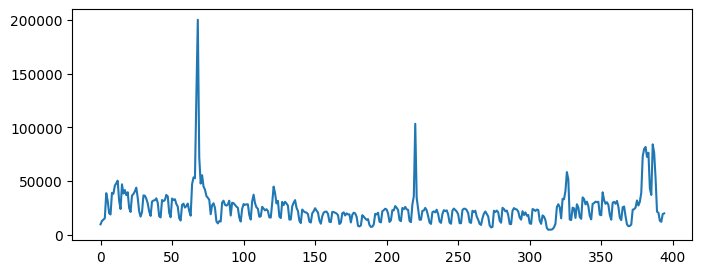

In [18]:
plt.figure(figsize=(8, 3))
plt.plot(data_source)
plt.show()

## 訓練集

原始資料 (316, 1)
[[4825]
 [4981]
 [4912]]
原始資料2 (301, 1)
[[4825]
 [4981]
 [4912]]
還原原始資料 (301, 1)
[[-21084.9575124 ]
 [-21000.57634184]]


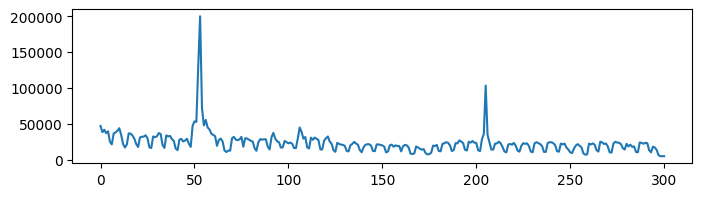

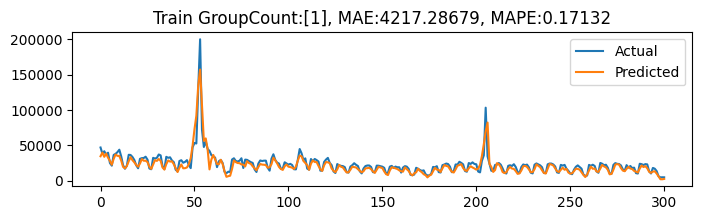

In [19]:
print('原始資料' , y_train_origin.shape)
print(y_train_origin[-3:])

print('原始資料2', y_lstm_origin_train.shape)
print(y_lstm_origin_train[-3:])

print('還原原始資料', actual_inverse_train.shape)
print(actual_inverse_train[-2:])

lstm.show_predict_chart(
    actual = y_lstm_origin_train,
    predict = predict_inverse_train_sum,
    title = f'Train {labels[0]}:{predicteds}, MAE:{round(mae_train, 5)}, MAPE:{round(mape_train, 5)}'
)

## 驗證集

原始資料 (39, 1)
[[32478]
 [29006]
 [30415]]
原始資料2 (24, 1)
[[32478]
 [29006]
 [30415]]
還原原始資料 (24, 1)
[[-22564.45898658]
 [-21070.98591439]]


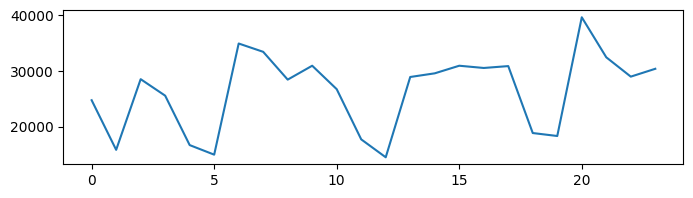

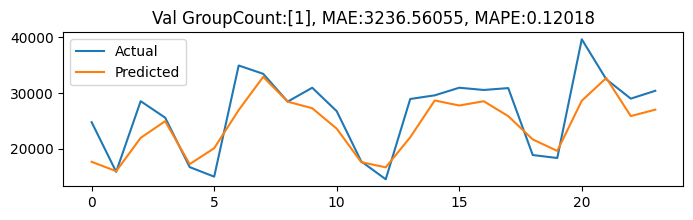

In [20]:
print('原始資料' , y_val_origin.shape)
print(y_val_origin[-3:])

print('原始資料2', y_lstm_origin_val.shape)
print(y_lstm_origin_val[-3:])

print('還原原始資料', actual_inverse_val.shape)
print(actual_inverse_val[-2:])

lstm.show_predict_chart(
    actual = y_lstm_origin_val,
    predict = predict_inverse_val_sum,
    title = f'Val {labels[0]}:{predicteds}, MAE:{round(mae_val, 5)}, MAPE:{round(mape_val, 5)}'
)

## 測試集

原始資料 (40, 1)
[[12238]
 [19482]
 [20069]]
原始資料2 (25, 1)
[[12238]
 [19482]
 [20069]]
還原原始資料 (25, 1)
[[-19895.51410989]
 [-21910.72968032]]
Test GroupCount:[1], BatchSize:14, MAE:7331.44133, MAPE:0.18669


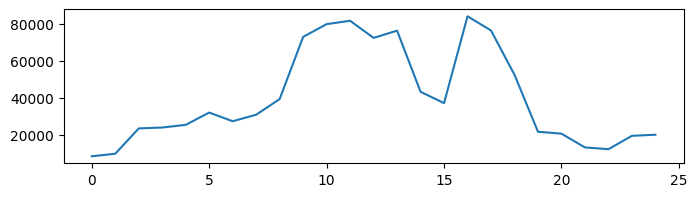

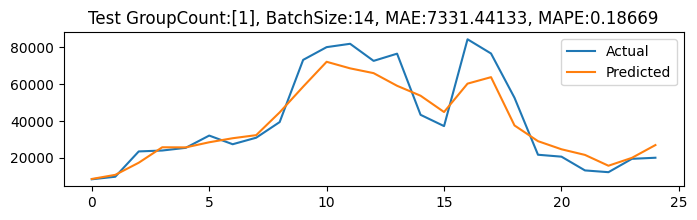

In [21]:
print('原始資料' , y_test_origin.shape)
print(y_test_origin[-3:])

print('原始資料2', y_lstm_origin_test.shape)
print(y_lstm_origin_test[-3:])

print('還原原始資料', actual_inverse_test.shape)
print(actual_inverse_test[-2:]) 

title = f'Test {labels[0]}:{predicteds}, BatchSize:{batch_size}, MAE:{round(mae_test, 5)}, MAPE:{round(mape_test, 5)}'
print(title)

lstm.show_predict_chart(
    actual = y_lstm_origin_test,
    predict = predict_inverse_test_sum,
    title = title
)

# 儲存結果

In [22]:
lstm.save_json_file(
    result_file_name, model_dir, labels, model_type, predicteds, 
    batch_size, mae_train, mape_train, mae_test, mape_test,
    imfs = len(imfs)
)

{'type': 'DecompEEMD', 'labels': ['GroupCount'], 'model_type': 2, 'predicteds': [1], 'batch_size': 14, 'train_mae': 4217.28679, 'train_mape': 0.17132, 'test_mae': 7331.44133, 'test_mape': 0.18669, 'kfold': None, 'imfs': 9}
儲存評估結果到 DecompEEMD/_Model/GroupCount_mt2_data1_batch14.result.json
